# Dog Shelter

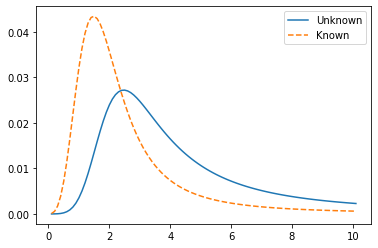

In [1]:
from scipy.stats import weibull_min
import numpy as np
import pandas as pd
import seaborn as sns

# Let's reproduce the dog adoption model.

# create a weibull distribution with parameters lambda=3 and k=.8
lbd, k = 3, .8
sample = 10
observation_days = 8
dist = weibull_min(k, scale=lbd)

# generate some sample data (10) out of above distribution to compute residence times. It
# will simulate the adoption rate. The arrival time should be uniform over 8 days whereas 
# the departure date should be the arrival + the residence time. Set seeds 19 & 17 to
# generate the uniform and the weibull variates.
np.random.seed(17)
lifetime = dist.rvs(sample)
np.random.seed(19)
arrival_date = np.random.uniform(0, observation_days, size=sample)

# Create a df with above data and tag censored rows, that is, the rows whose depart date
# is beyond the 8 days. Also create a column T with the duration.
departure = arrival_date + lifetime
data = pd.DataFrame({
    "arrival": arrival_date,
    "departure": departure,
    "lifetime": lifetime,
    "still_life": 8 - arrival_date,
    "still_alive": departure > 8,
}).sort_values(by='arrival', ignore_index=True)

data["future"] = False
future = data.departure > observation_days
data.loc[future, "future"] = True

# Compute the bayesian update of the non-censored rows
hs_size = 101
lbd_range = np.linspace(0.1, 10.1, hs_size)
k_range = np.linspace(0.1, 5.1, hs_size)
prior = np.ones((hs_size, hs_size)) / hs_size**2

observations = data[data.still_alive == False].lifetime
lbds, ks, obs = np.meshgrid(lbd_range, k_range, observations)
likes = weibull_min(ks, scale=lbds).pdf(obs).prod(axis=2)

posterior_known = prior.copy() * likes
posterior_known = posterior_known / posterior_known.sum()

posterior_known = pd.DataFrame(
    data=posterior_known, index=lbd_range, columns=k_range
)

# Compute the bayesian update of the censored rows. This differs from the above in that we
# use the survival function instead of the pdf
observations = data[data.still_alive == True].still_life
lbds, ks, obs = np.meshgrid(lbd_range, k_range, observations)
likes = weibull_min(ks, scale=lbds).sf(obs).prod(axis=2)

posterior_unknown = posterior_known.values * likes
posterior_unknown = posterior_unknown / posterior_unknown.sum()

posterior_unknown = pd.DataFrame(
    data=posterior_unknown, index=lbd_range, columns=k_range
)

# Plot marginals of lambda for both parts
u_lbd = posterior_unknown.sum(axis=0)
k_lbd = posterior_known.sum(axis=0)
sns.lineplot(x=lbd_range, y=u_lbd, label="Unknown");
sns.lineplot(x=lbd_range, y=k_lbd, label="Known", linestyle="dashed");

# Light bulbs

14.627932293262592

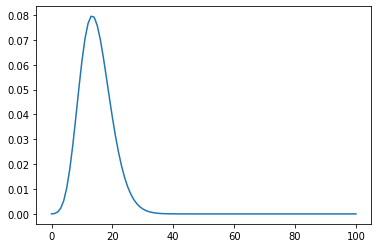

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom

def heatmap(data, title=None, xlabel=None, ylabel=None):
    _, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(data, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel), ax.set_ylabel(ylabel)

# Import the data from lamps.csv
data = pd.read_csv("lamps.csv", index_col=0)


# Create prior uniform distributions:
hs_size = 51
k_range = np.linspace(1, 10, hs_size)
lbd_range = np.linspace(1e3, 2e3, hs_size)
prior = (np.ones(hs_size**2) / hs_size**2).reshape((51, 51))


# transform the dataset to have 50 elements instead of 32
lifetimes = np.repeat(data["h"], data["f"]).reset_index(drop=True)


# Make the bayesian update.
k_mesh, lbd_mesh, data_mesh = np.meshgrid(k_range, lbs_range, lifetimes)
likes = weibull_min(k_mesh, scale=lbd_mesh).pdf(lifetimes).prod(axis=2)

# sanity check plot
# likes = pd.DataFrame(likes, index=lbd_range, columns=k_range)
# heatmap(likes, title="Likelihood", xlabel="k_range", ylabel="lbd_range")
post = prior * likes
post = post / post.sum()


# Compute the posterior mean.
hs = np.meshgrid(k_range, lbs_range)
hs_mean = weibull_min(hs[0], hs[1]).mean()
# Sanity check plot
# hs_mean = pd.DataFrame(hs_mean, index=lbd_range, columns=k_range)
# heatmap(hs_mean, title="hs_mean", xlabel="k_range", ylabel="lbd_range")

post_mean = pd.DataFrame(post * hs_mean, index=lbd_range, columns=k_range)
# Sanity check plot
# post_mean.sum(axis=1).plot();


# Fine tune for lamps dying in the 12h stint. In this case to compute the likes we want
# a middle ground between the cdf of dying at the time we wacht it and the time right
# right after the last measurement
likes_end = weibull_min(k_mesh, scale=lbd_mesh).cdf(data_mesh)
likes_start = weibull_min(k_mesh, scale=lbd_mesh).cdf(data_mesh - 12)
likes_tuned = (likes_end - likes_start).prod(axis=2)
post_tuned = likes_tuned * prior
post_tuned = post_tuned / post_tuned.sum()
post_tuned_mean = pd.DataFrame(post_tuned * hs_mean, index=lbd_range, columns=k_range)
# Sanity check plot
# post_tuned_mean.sum(axis=1).plot()


# Predict how many lightbulbs will be active after 1k hours.
t = 1000
k, lbd = 3, 1500
p = weibull_min(k, scale=lbd).cdf(t)
hs = np.arange(101)  # how many lightbulbs have died out of the 100 including 0
bd = binom.pmf(hs, 100, p)
# Sanity check plot
# sns.lineplot(x=hs, y=bd)


k_mesh, lbd_mesh = np.meshgrid(k_range, lbd_range)
ps = weibull_min(k_mesh, scale=lbd_mesh).cdf(t)
# Sanity check plot
# ps_df = pd.DataFrame(ps, index=lbd_range, columns=k_range)
# heatmap(
#     ps_df, title="% of light bulbs dead.",
#     xlabel="K range", ylabel="Lambda range"
# )
hs_mesh, p_mesh = np.meshgrid(hs, ps.ravel())
bd = binom.pmf(hs_mesh, 100, p_mesh)
binomials_df = pd.DataFrame(bd, columns=hs)

(post.ravel() * binomials_df.T).sum(axis=1).plot()

np.sum(hs * (post.ravel() * binomials_df.T).sum(axis=1))